# 뉴스 제목으로 기사 분류하기 _ 허채범

## 출처

데이터 : https://dacon.io/competitions/official/235747/data  
한국어 불용어1 : https://deep.chulgil.me/hangugeo-bulyongeo-riseuteu/  
한국어 불용어2 : https://www.ranks.nl/stopwords/korean

In [63]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 글씨체
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from konlpy.tag import Okt, Kkma, Komoran

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings 
warnings.filterwarnings(action='ignore')

# 1. 데이터 관련
---

In [2]:
# 데이터 로딩
train = pd.read_csv('./data/train_data.csv', encoding='euc-kr')
test = pd.read_csv('./data/test_data.csv', encoding='euc-kr')
topic = pd.read_csv('./data/topic_dict.csv', encoding='euc-kr')

In [3]:
# 훈련 데이터 확인 (결측치x)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [4]:
# train의 기사 제목(title) 확인
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [5]:
y_train = train['topic_idx']

1) 제목이다 보니, 명사화되어 끝나는 단어들이 많음 => 단어 단위로 토큰화  
2) '...'가 많이 들어감 => 불용어 처리  
3) 영어나 한자의 경우, 국가나 국제 단체를 의미하는 경우가 대다수 => 영어나 한자 삭제  
4) 뉴스의 제목이다 보니, 비교적 신조어나 비속어 같은 것들은 없음 => 크게 신경x  
5) 제목이라서, 전체적 내용의 핵심을 담고 있기 때문에 분류가 잘 되지 않을까 생각

In [6]:
# test의 기사 제목(title) 확인
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


,0,1,2,3,4,5,6
topic,IT과학,경제,사회,생활문화,세계,스포츠,정치
topic_idx,0,1,2,3,4,5,6


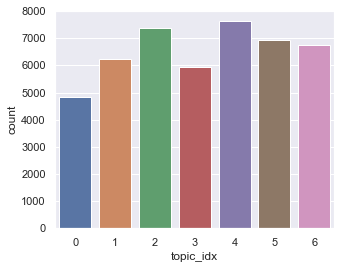

In [7]:
# 주제별 제목 개수 확인 (for 훈련 데이터 분포)

sns.set(rc={'figure.figsize':(5,4)})
sns.set_theme(style="darkgrid")
sns.countplot(data= train, x = 'topic_idx')

topic.T

In [8]:
# 기사 주제별 제목 개수
train['topic_idx'].value_counts(dropna=False, ascending=True)

0    4824
3    5933
1    6222
6    6751
5    6933
2    7362
4    7629
Name: topic_idx, dtype: int64

In [9]:
# # 훈련 data 문장들의 길이

# titles = train['title']
# train_lengths = [len(t) for t in titles]

# plt.figure(figsize=(10, 5))
# plt.hist(train_lengths, bins=20, color='tomato')
# plt.show()

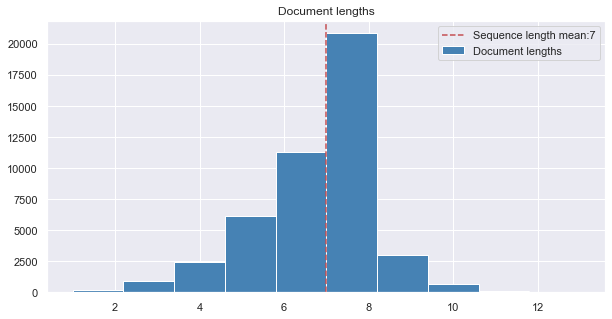

[가장  긴  문장] : 13 개의 단어가 있음
[가장 짧은 문장] : 1  개의 단어가 있음


In [10]:
# 문장의 단어수 확인

# 띄어쓰기를 기준으로 단어를 나누었을 때, 제목 1개에 포함된 단어 수를 나타내는 컬럼 추가
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

# [ doc_len ]컬럼의 평균값
mean_seq_len = np.round(train.doc_len.mean()).astype(int)

plt.figure(figsize=(10, 5))
plt.axvline(x=mean_seq_len, color='r', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
plt.hist(train['doc_len'], bins=10, color='steelblue', label='Document lengths')
plt.title('Document lengths')
plt.legend()
plt.show()

print(f"[가장  긴  문장] : {train['doc_len'].max()} 개의 단어가 있음\n[가장 짧은 문장] : {train['doc_len'].min()}  개의 단어가 있음")

In [11]:
# 제목 1개에 들어있는 단어의 개수
doc_lenDF = pd.DataFrame(train['doc_len'])
doc_lenDF.describe().T

# 평균, 최소, 최대 재확인

,count,mean,std,min,25%,50%,75%,max
doc_len,45654.0,6.588207,1.474083,1.0,6.0,7.0,8.0,13.0


In [12]:
# Train 데이터 불균형 (SMOTE 사용)

In [13]:
# !pip install -U imbalanced-learn
# !pip install scikit-learn --user --upgrade
# !pip install transformers

# 2. 텍스트 전처리

x 1. 띄어쓰기 -> 띄어쓰기 제대로 반영

o 2. 한글 표현만 남기기 -> 날릴 수 있는 단어 가시화

o 3. Okt -> 각 뉴스 제목을 형태소 단위로 분리

o 4. 한글자 & 불용어 -> 제거

o 5. 빈도수가 많은 순으로 정렬 -> 불용어 제거

o 6. 최소빈도수 이하(10회) -> 제거

### 2-1) 띄어쓰기

In [14]:
# 띄어쓰기 고치기 모델 => pykospacing 패키지 (오류 문제로 설치 실패)
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [ ]:
# ~종합 이렇게 붙은 것들 처리하기 위해
# (for 있는 것들 찾아서 빈도수 낮다면 제거)
print(train['title'][1149])
print(train['title'][1151])

### 2-2) 한글 표현만 남기기

In [15]:
# 1) 한자나 영단어 => 일단 삭제, 명사들이 많아서 커버 될 것으로 생각
# -> 어차피 빈도수가 적어서 삭제 대상에 들어갈 것으로 판단

# 2) 숫자 => ex) 3월  =>  숫자 날아가고 '월'  =>  1글자 불용어로 삭제 대상

def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

print("제거 전  : ", train['title'][0])
print("제거 후  : ", extract_word(train['title'][0]))

제거 전  :  인천→핀란드 항공기 결항…휴가철 여행객 분통
제거 후  :  인천 핀란드 항공기 결항 휴가철 여행객 분통


In [16]:
# 전체 데이터에 대해 extract_word를 적용
# i)

train['title'] = train['title'].apply(lambda x:extract_word(x))
test['title'] = test['title'].apply(lambda x:extract_word(x))

In [17]:
# ii) 

# for i in tqdm(range(len(train['title']))):
#     hangul = re.compile('[^가-힣]') 
#     train['title'][i] = hangul.sub(' ', train['title'][i])

# for i in tqdm(range(len(train['title']))):
#     hangul = re.compile('[^가-힣]') 
#     test['title'][i] = hangul.sub(' ', test['title'][i])

In [18]:
train['title']

0                  인천 핀란드 항공기 결항 휴가철 여행객 분통
1            실리콘밸리 넘어서겠다 구글   조원 들여  전역 거점화
2            이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3              클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4                 시진핑 트럼프에 중미 무역협상 조속 타결 희망
                        ...                
45649            금융 미국    스티펠과 제휴 선진국 시장 공략
45650        보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토
45651           게시판 키움증권      키움 영웅전 실전투자대회
45652                     답변하는 배기동 국립중앙박물관장
45653         한국인터넷기자상 시상식 내달  일 개최 특별상 김성후
Name: title, Length: 45654, dtype: object

### 2-3)  토큰화 ( Okt 사용 )

In [19]:
# 구성하는 형태소를 살피기 위해 토큰화 진행
okt = Okt()
words = " ".join(train['title'].tolist())
words = okt.morphs(words,stem=True)
print(len(words))

432062


### 2-4) 한글자로 된 단어 삭제

In [20]:
# 한글자로 된 단어 삭제
remove_one_word = [x for x in words if len(x)>1]
len(remove_one_word)

333824

In [21]:
# 한글자로 구분된 것 삭제 후, 카운팅
from collections import Counter
Counter(remove_one_word).most_common()

[('하다', 4288),
 ('종합', 4056),
 ('대통령', 1723),
 ('한국', 1456),
 ('으로', 1413),
 ('억원', 908),
 ('삼성', 904),
 ('이란', 856),
 ('되다', 852),
 ('감독', 778),
 ('출시', 778),
 ('경기', 760),
 ('만에', 754),
 ('없다', 742),
 ('게시판', 735),
 ('에서', 714),
 ('트럼프', 702),
 ('보다', 698),
 ('신간', 686),
 ('까지', 682),
 ('정부', 603),
 ('투자', 599),
 ('개발', 594),
 ('분기', 584),
 ('대다', 582),
 ('부터', 579),
 ('서울', 573),
 ('지원', 557),
 ('최고', 517),
 ('중국', 511),
 ('올해', 508),
 ('민주', 496),
 ('개최', 487),
 ('영업', 479),
 ('세계', 472),
 ('현대', 470),
 ('미국', 462),
 ('공개', 459),
 ('기업', 451),
 ('기술', 451),
 ('증권', 441),
 ('코로나', 440),
 ('작년', 434),
 ('대표', 432),
 ('금융', 430),
 ('시장', 428),
 ('있다', 426),
 ('게임', 417),
 ('최대', 417),
 ('김정은', 412),
 ('총리', 408),
 ('북한', 400),
 ('월드컵', 396),
 ('서비스', 396),
 ('사망', 393),
 ('전자', 393),
 ('축제', 387),
 ('국내', 386),
 ('돼다', 384),
 ('시즌', 382),
 ('사업', 382),
 ('류현진', 381),
 ('받다', 380),
 ('터키', 378),
 ('전국', 377),
 ('합의', 373),
 ('그래픽', 371),
 ('여행', 370),
 ('추진', 369),
 ('대회', 358),
 ('않다'

- 빈도수 위주로 출력하였는데, 아직까지 불용어가 많이 보임
- 불용어 사전 추가 => '하다','으로','되다' 등 이런 것들은 불용어리스트로 정의해 한번 더 걸러내야 함

### 2-5)  빈도수로 정렬 후, 불용어 제거

In [22]:
# 1차 불용어를 제거 (기존의 다운받은 불용어 txt 우선 실행)
with open('data/stopwords.txt', 'r') as f:
    list_file = f.readlines()
stopwords = list_file[0].split(",")

remove_stopwords = [x for x in remove_one_word if x not in stopwords]
len(remove_stopwords)

306687

In [23]:
# 1차 불용어 제거 후, 카운팅
from collections import Counter
# words.sort()
Counter(remove_stopwords).most_common()

[('종합', 4056),
 ('대통령', 1723),
 ('한국', 1456),
 ('억원', 908),
 ('삼성', 904),
 ('감독', 778),
 ('출시', 778),
 ('경기', 760),
 ('게시판', 735),
 ('트럼프', 702),
 ('신간', 686),
 ('정부', 603),
 ('투자', 599),
 ('개발', 594),
 ('분기', 584),
 ('서울', 573),
 ('지원', 557),
 ('최고', 517),
 ('중국', 511),
 ('민주', 496),
 ('개최', 487),
 ('영업', 479),
 ('세계', 472),
 ('현대', 470),
 ('미국', 462),
 ('공개', 459),
 ('기업', 451),
 ('기술', 451),
 ('증권', 441),
 ('코로나', 440),
 ('작년', 434),
 ('대표', 432),
 ('금융', 430),
 ('시장', 428),
 ('게임', 417),
 ('최대', 417),
 ('김정은', 412),
 ('총리', 408),
 ('북한', 400),
 ('월드컵', 396),
 ('서비스', 396),
 ('사망', 393),
 ('축제', 387),
 ('국내', 386),
 ('시즌', 382),
 ('사업', 382),
 ('류현진', 381),
 ('터키', 378),
 ('전국', 377),
 ('합의', 373),
 ('그래픽', 371),
 ('여행', 370),
 ('추진', 369),
 ('대회', 358),
 ('네이버', 356),
 ('장관', 354),
 ('내년', 354),
 ('방문', 353),
 ('부산', 353),
 ('연승', 351),
 ('크다', 349),
 ('연속', 348),
 ('회의', 346),
 ('축구', 343),
 ('제재', 340),
 ('갤럭시', 337),
 ('확대', 336),
 ('시위', 328),
 ('개다', 320),
 ('국회', 320),
 ('협력'

In [24]:
# 2차 불용어를 제거 ( txt 파일명을 따로 하여 추가적으로 불용어 제거 실행 )
with open('data/stopwords_2.txt', 'r') as f:
    list_file = f.readlines()
stopwords = list_file[0].split(",")
remove_stopwords = [x for x in remove_stopwords if x not in stopwords]
len(remove_stopwords)

292107

In [25]:
# 추가된 단어
print(stopwords)

['하다', '으로', '되다', '만에', '없다', '에서', '보다', '까지', '대다', '부터', '있다', '돼다', '받다', '않다', '에도', '맞다', '이다', '추다', '가다', '번째', '만들다', '서다', '다시', '관련', '늘다', '위해', '많다', '주다', '나오다', '아니다', '함께', '만나다', '들다', '하고', '오르다', '알다', '열리다', '놓다', '이후', '이번', '없이', '지만', '어떻다', '같다', '따르다', '자다', '잇다', '키우다', '찾다', '이르다', '뜨다', '어렵다', '지난해', '돌아오다', '바꾸다', '끝나다', '나누다', '커지다', '흐리다', '늘리다', '잇따르다', '지키다', '열다', '밝히다', '높이다', '숨지다', '돌보다', '빠지다', '강하다', '만의', '잡다', '쓸다', '즐기다', '떠나다', '종합', '억원', '크다', '꺾다', '밉다', '앞두다', '좋다', '이틀', '사실', '마감', '천억원', '최소', '천명', '통과', '주요', '공식', '새롭다', '긴급', '나서다', '이벤트', '활용', '일정', '곳곳', '마련', '개국', '연합', '당국', '뛰다', '첫날', '남부', '공공', '연결', '코리아', '실패', '중동', '도시', '기회', '희망', '완화', '관계', '방안', '결의', '천원', '관심', '변경', '진행', '장기', '바른', '철회', '국립', '전남', '키로', '통화', '이유', '회사', '지정', '핵심', '조기', '발생', '차량', '기부', '북부', '달라', '직접', '질주', '최종', '시리즈', '집단', '강조']


In [26]:
# 재확인 ( for 개인적으로 불용어 사전에 추가할 단어 탐색 )
from collections import Counter
Counter(remove_stopwords).most_common()

# 하다, 으로 등 상위에 랭크 되어 있던 것들이 사라짐 => 제대로 제거됨

[('대통령', 1723),
 ('한국', 1456),
 ('삼성', 904),
 ('감독', 778),
 ('출시', 778),
 ('경기', 760),
 ('게시판', 735),
 ('트럼프', 702),
 ('신간', 686),
 ('정부', 603),
 ('투자', 599),
 ('개발', 594),
 ('분기', 584),
 ('서울', 573),
 ('지원', 557),
 ('최고', 517),
 ('중국', 511),
 ('민주', 496),
 ('개최', 487),
 ('영업', 479),
 ('세계', 472),
 ('현대', 470),
 ('미국', 462),
 ('공개', 459),
 ('기업', 451),
 ('기술', 451),
 ('증권', 441),
 ('코로나', 440),
 ('작년', 434),
 ('대표', 432),
 ('금융', 430),
 ('시장', 428),
 ('게임', 417),
 ('최대', 417),
 ('김정은', 412),
 ('총리', 408),
 ('북한', 400),
 ('월드컵', 396),
 ('서비스', 396),
 ('사망', 393),
 ('축제', 387),
 ('국내', 386),
 ('시즌', 382),
 ('사업', 382),
 ('류현진', 381),
 ('터키', 378),
 ('전국', 377),
 ('합의', 373),
 ('그래픽', 371),
 ('여행', 370),
 ('추진', 369),
 ('대회', 358),
 ('네이버', 356),
 ('장관', 354),
 ('내년', 354),
 ('방문', 353),
 ('부산', 353),
 ('연승', 351),
 ('연속', 348),
 ('회의', 346),
 ('축구', 343),
 ('제재', 340),
 ('갤럭시', 337),
 ('확대', 336),
 ('시위', 328),
 ('개다', 320),
 ('국회', 320),
 ('협력', 318),
 ('선수', 318),
 ('코스피', 318),
 ('논란'

### 2-6)  최소 빈도수 이하의 것들은 제거
- [ remove_stopwords ] : 현재 전처리 모두 거친 것

---

In [27]:
# Counter를 활용, 내림차순으로 ('단어', 빈도수) 살피기
from collections import Counter
x = Counter(remove_stopwords)
low_list = list(reversed(x.most_common()))
low_list

[('김성후', 1),
 ('스티펠', 1),
 ('동일본', 1),
 ('받아쓰기', 1),
 ('정진후', 1),
 ('깜빡', 1),
 ('동거인', 1),
 ('잉태', 1),
 ('만큼도', 1),
 ('듀엣', 1),
 ('박재근', 1),
 ('박명숙', 1),
 ('팀버불스', 1),
 ('울브스', 1),
 ('팀버', 1),
 ('죽서루', 1),
 ('관동팔경', 1),
 ('낙도', 1),
 ('행정가', 1),
 ('거룩하다', 1),
 ('멍키', 1),
 ('이부영', 1),
 ('무랄랴', 1),
 ('입헌민주당', 1),
 ('판매업', 1),
 ('결여', 1),
 ('공생', 1),
 ('배앓이', 1),
 ('옥자', 1),
 ('실사판', 1),
 ('컬트', 1),
 ('시스터', 1),
 ('알코올', 1),
 ('금천구', 1),
 ('송진', 1),
 ('레싱', 1),
 ('저먼윙스', 1),
 ('색감', 1),
 ('성새', 1),
 ('행군', 1),
 ('고난', 1),
 ('대별', 1),
 ('데이즈', 1),
 ('바바리안', 1),
 ('의왕', 1),
 ('참선', 1),
 ('홍조', 1),
 ('손사래', 1),
 ('노심초사', 1),
 ('보우', 1),
 ('월간지', 1),
 ('완행', 1),
 ('채보', 1),
 ('거닉', 1),
 ('지역방송국', 1),
 ('나그네', 1),
 ('귀로', 1),
 ('칙령', 1),
 ('장진용', 1),
 ('만학', 1),
 ('맹훈련', 1),
 ('혼연', 1),
 ('시로', 1),
 ('삼행', 1),
 ('티센크루프', 1),
 ('포피', 1),
 ('조용준', 1),
 ('사무라이', 1),
 ('떠내려가다', 1),
 ('브라이튼', 1),
 ('발독', 1),
 ('툴젠', 1),
 ('플라멩구', 1),
 ('마녀사냥', 1),
 ('건보', 1),
 ('은세계', 1),
 ('사하', 1),
 ('위구르족', 1),
 

In [28]:
print(f'현재 남은 총 단어 개수 : {len(remove_stopwords)} 개')
print(f'현재 남은 키워드 종류  : {len(low_list)} 개')
print(f'(빈도)오름차순일 때, 마지막 키워드 : {low_list[25144]}')

현재 남은 총 단어 개수 : 292107 개
현재 남은 키워드 종류  : 25145 개
(빈도)오름차순일 때, 마지막 키워드 : ('대통령', 1723)


In [29]:
# print(f'10000번째 키워드 : {del_list[10000]}')
print(f'20000번째 키워드 : {low_list[20000]}')
print('(빈도)오름차순일 때, 0 ~ 20000 까지의 키워드는 빈도수 10회 이하')

20000번째 키워드 : ('구원', 10)
(빈도)오름차순일 때, 0 ~ 20000 까지의 키워드는 빈도수 10회 이하


---

In [30]:
# 빈도수만 맞추려다 키워드 개수가 확 줄어버릴지도 모르겠다는 생각이 들어서
# 일단, 빈도수 3회이하까지만 삭제

item_c = []

for item, count in Counter(remove_stopwords).most_common():
    if count<=10:
        item_c.append(item)
#         print(item, count)

print(f'이런식으로 출력됨 => ({item}, {count})')        

이런식으로 출력됨 => (김성후, 1)


In [31]:
print(f'빈도수 10회 이하인 것들의 키워드 개수 : {len(item_c)}개')

빈도수 10회 이하인 것들의 키워드 개수 : 20262개


In [32]:
from tqdm import notebook
import time

minimum_count = 10
train_ver1 = []

for i in notebook.tqdm(range(len(remove_stopwords))):
    tmp = remove_stopwords[i]
    if remove_stopwords.count(tmp) >= minimum_count:
        train_ver1.append(tmp)

  0%|          | 0/292107 [00:00<?, ?it/s]

In [33]:
len(train_ver1)

240528

In [34]:
# 중복제거 안된 상태 (T^T)
len(train_ver1)

240528

In [35]:
# 중복제거 된 상태 (T^T)
# len(set(train_ver1))
train_ver1 = list(set(train_ver1))
len(train_ver1)

5281

### 2-7) 단어사전 생성

In [36]:
# 단어에 인덱스 부여 => 단어사전 생성 
def word2seq():
    word_index={}
    maxNum=len(train_ver1)
    for idx in range(maxNum):
        print(idx, '-', train_ver1[idx]) 
        word_index[train_ver1[idx]]=idx+1
        
    return word_index

In [37]:
# 토큰에 번호 부여한 단어 사전 생성
word_voca= word2seq()

0 - 정치인
1 - 대가
2 - 연쇄
3 - 박지수
4 - 접근
5 - 김영철
6 - 늦추다
7 - 계절
8 - 현실
9 - 지주
10 - 행성
11 - 표창
12 - 서점
13 - 신입사원
14 - 계산
15 - 걷다
16 - 코오롱
17 - 맨시티
18 - 첼리스트
19 - 결승골
20 - 부과
21 - 배제
22 - 석탄
23 - 라스베이거스
24 - 억지
25 - 보유
26 - 터지다
27 - 화제
28 - 완패
29 - 무료
30 - 의정부
31 - 탁원
32 - 지식
33 - 후기
34 - 편입
35 - 참다
36 - 예의
37 - 민주화
38 - 보완
39 - 옵션
40 - 대전
41 - 답변
42 - 패럴림픽
43 - 아가
44 - 생명
45 - 토론
46 - 맞서다
47 - 정운찬
48 - 북미
49 - 쓰레기
50 - 화두
51 - 쿠바
52 - 스파이
53 - 합창
54 - 시행
55 - 우라늄
56 - 청정
57 - 속초
58 - 주춤
59 - 무덤
60 - 순간
61 - 신탁
62 - 묶이다
63 - 동물
64 - 철학
65 - 비싸다
66 - 상봉
67 - 정의
68 - 분양
69 - 부적절
70 - 잠자다
71 - 텔레콤
72 - 노르웨이
73 - 쿠르드
74 - 영호
75 - 제로
76 - 공백
77 - 전투
78 - 고지
79 - 입국
80 - 미치다
81 - 억제
82 - 사표
83 - 방한
84 - 선두
85 - 노트북
86 - 사태
87 - 특수
88 - 촛불
89 - 직스
90 - 정체
91 - 기업
92 - 권법
93 - 리얼미터
94 - 현대차
95 - 농축
96 - 울산
97 - 반격
98 - 합성
99 - 연극
100 - 우천
101 - 간섭
102 - 재벌
103 - 수도권
104 - 엇갈리다
105 - 미래
106 - 이정후
107 - 배경
108 - 포퓰리즘
109 - 사주
110 - 국민은행
111 - 재난
112 - 러블
113 - 전용
114 - 대선
115 - 오염
116 - 쌀쌀
117 - 통통
11

1411 - 몰이
1412 - 신고
1413 - 구도
1414 - 블로킹
1415 - 검열
1416 - 남편
1417 - 국회의장
1418 - 보통
1419 - 특강
1420 - 야권
1421 - 태세
1422 - 높다
1423 - 종료
1424 - 의존
1425 - 인터파크
1426 - 그린
1427 - 상처
1428 - 안녕
1429 - 패치
1430 - 학원
1431 - 인스타그램
1432 - 디우프
1433 - 외교부
1434 - 선사
1435 - 실력
1436 - 사형
1437 - 점차
1438 - 셀트리온
1439 - 물질
1440 - 구형
1441 - 완판
1442 - 년대
1443 - 예산안
1444 - 붕괴
1445 - 나와라
1446 - 경쟁률
1447 - 안양
1448 - 수괴
1449 - 주차
1450 - 바르다
1451 - 일시
1452 - 추진
1453 - 안전하다
1454 - 일보
1455 - 알파
1456 - 실제
1457 - 제약
1458 - 현황
1459 - 야당
1460 - 농협
1461 - 호실
1462 - 권유
1463 - 신혼부부
1464 - 의대
1465 - 신한은행
1466 - 관영
1467 - 중력파
1468 - 청문회
1469 - 구글플레이
1470 - 라임
1471 - 백두산
1472 - 스완지시티
1473 - 자동
1474 - 국적
1475 - 대설
1476 - 주의
1477 - 호날두
1478 - 공작
1479 - 네이버
1480 - 제천
1481 - 부진
1482 - 인용
1483 - 상담
1484 - 탈삼진
1485 - 경계
1486 - 붙다
1487 - 발동
1488 - 승소
1489 - 청주
1490 - 티노
1491 - 한국은행
1492 - 산전
1493 - 소리
1494 - 이용
1495 - 교정
1496 - 파견
1497 - 일반
1498 - 벌금형
1499 - 끊다
1500 - 굴욕
1501 - 공익
1502 - 추정
1503 - 컵스
1504 - 전역
1505 - 교실
1506 - 타수
150

2911 - 가리다
2912 - 위반
2913 - 유심
2914 - 정상화
2915 - 선언
2916 - 이청용
2917 - 아리랑
2918 - 수익
2919 - 개관
2920 - 농구
2921 - 야외
2922 - 시너지
2923 - 아르헨
2924 - 물고기
2925 - 황희
2926 - 캄보디아
2927 - 연속
2928 - 캐피탈
2929 - 수해
2930 - 공인
2931 - 이적
2932 - 항만
2933 - 마크
2934 - 테이블
2935 - 체인
2936 - 선전
2937 - 도전
2938 - 서훈
2939 - 교육
2940 - 중독
2941 - 챙기다
2942 - 수렁
2943 - 원장
2944 - 공고
2945 - 네트워크
2946 - 인재
2947 - 특허
2948 - 자처
2949 - 탈당
2950 - 우승하다
2951 - 경쟁
2952 - 개헌안
2953 - 번영
2954 - 노선
2955 - 유통업
2956 - 명인
2957 - 초연
2958 - 게임
2959 - 촉구
2960 - 살해
2961 - 해병대
2962 - 어리다
2963 - 봉쇄
2964 - 콜로라도
2965 - 늙다
2966 - 체감
2967 - 북중
2968 - 청약
2969 - 베팅
2970 - 어려워지다
2971 - 영남
2972 - 연내
2973 - 이재명
2974 - 입성
2975 - 대화
2976 - 불량
2977 - 한일
2978 - 송영길
2979 - 나쁘다
2980 - 세미나
2981 - 교체
2982 - 반군
2983 - 쑥쑥
2984 - 수당
2985 - 소통
2986 - 가까워지다
2987 - 수십
2988 - 시험대
2989 - 판독
2990 - 방출
2991 - 대치
2992 - 고용노동부
2993 - 세포
2994 - 광산
2995 - 리치
2996 - 공정하다
2997 - 울다
2998 - 돌아가다
2999 - 배우
3000 - 호흡
3001 - 부서
3002 - 요인
3003 - 통신사
3004 - 아람
3005 - 목포
3006 - 베네

4577 - 만점
4578 - 배출
4579 - 강의
4580 - 김지영
4581 - 지침
4582 - 무장
4583 - 분명하다
4584 - 만대
4585 - 개발자
4586 - 항공기
4587 - 개장
4588 - 역풍
4589 - 레이더
4590 - 유치원
4591 - 일방
4592 - 크리스마스
4593 - 할인
4594 - 방종하다
4595 - 제도
4596 - 미생물
4597 - 석유
4598 - 아시안컵
4599 - 감정
4600 - 목사
4601 - 공짜
4602 - 로버츠
4603 - 한상혁
4604 - 방지
4605 - 태운
4606 - 순방
4607 - 비결
4608 - 환수
4609 - 뮌헨
4610 - 불참
4611 - 마르다
4612 - 참여
4613 - 종결
4614 - 망명
4615 - 태풍
4616 - 오키나와
4617 - 난항
4618 - 포기
4619 - 놀이
4620 - 포인트
4621 - 과반
4622 - 허가
4623 - 대표
4624 - 미만
4625 - 배신
4626 - 평가
4627 - 제주도
4628 - 신경
4629 - 그대로
4630 - 대권
4631 - 행렬
4632 - 트럭
4633 - 지중해
4634 - 이탈
4635 - 수첩
4636 - 버리다
4637 - 독재
4638 - 천만원
4639 - 지주사
4640 - 중상
4641 - 에이스
4642 - 온도
4643 - 사령관
4644 - 박영선
4645 - 반복
4646 - 언론인
4647 - 크리스
4648 - 지상파
4649 - 검증
4650 - 펼쳐지다
4651 - 조처
4652 - 휘발유
4653 - 회화
4654 - 팔꿈치
4655 - 해외여행
4656 - 기용
4657 - 볼넷
4658 - 해제
4659 - 환호
4660 - 장터
4661 - 정의용
4662 - 겨냥
4663 - 포털
4664 - 신흥
4665 - 여파
4666 - 변동
4667 - 오전
4668 - 사법
4669 - 미리
4670 - 필드
4671 - 퍼지다
4672 - 겨울

In [38]:
# train_ver1[0], train_ver1[-1], train_ver1[5280]

In [39]:
# word_voca['저작권'], word_voca['디스플레이'] , len(word_voca)

### 2-8) 텍스트 문장을 정수 수치화

In [40]:
# 텍스트 문장을 수치화 변환 함수 
def sent2seq(sent):
    sentseq=[]
    for s in sent.split(' '):
#         print(f's => {s}')
        if s in word_voca:
#             print(f'{s}키 있음~~~~')
            sentseq.append(word_voca[s])
#         else:
#             print(f'{s}키 없음')
    return sentseq 

In [41]:
# 뉴스 타이틀만 가져와서 수치화 진행 (위의 함수 실행)
sentenceList = train['title'].tolist()
news_seq=[]
for sent in sentenceList:
    news_seq.append(sent2seq(sent))

In [42]:
print(news_seq[:10])

[[548, 2228, 4587, 4793, 3199], [2552, 168, 3051, 1505], [2118], [3730, 2225, 92, 718], [4977, 2296, 667, 4957], [4890, 3533, 4331, 3268], [2618, 4106, 2738, 1374, 375], [115, 46, 4091, 3755, 150], [2394, 3569, 2624, 1643, 1635, 4807], [5223, 4091, 1689, 3744, 897, 3068]]


In [43]:
# print(train['title'][2])
# sent2seq(train['title'][2])

### 2-9) 가변 길이 문장 => 고정 길이 문장

In [44]:
# 전체 뉴스 기사 문장 => 고정 길이 (패딩)
length=[]
for news in news_seq:
    length.append(len(news))
    
print(max(length), min(length))

10 0


In [45]:
news_seq = pad_sequences(news_seq, maxlen=max(length))

In [46]:
news_seq.shape

(45654, 10)

In [47]:
news_seq

array([[   0,    0,    0, ..., 4587, 4793, 3199],
       [   0,    0,    0, ...,  168, 3051, 1505],
       [   0,    0,    0, ...,    0,    0, 2118],
       ...,
       [   0,    0,    0, ...,    0,    0, 3348],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ..., 4746,  868, 1092]])

In [48]:
# y_train 원-핫 인코딩
from tensorflow.keras.utils import to_categorical
y_train_oh = to_categorical(y_train)
y_train_oh.shape

y_test_oh = to_categorical(y_train)

In [49]:
news_seq.shape, y_train_oh.shape

((45654, 10), (45654, 7))

In [50]:
news_seq[0]

array([   0,    0,    0,    0,    0,  548, 2228, 4587, 4793, 3199])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(news_seq, y_train_oh, random_state=42,
                                                    stratify=y_train_oh, test_size=0.2)

# 3. 모델링(modeling)

In [54]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size =  len(word_voca)+1
embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=10))
model.add(LSTM(10))
model.add(Dense(7, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [71]:
len(word_voca)+1

5282

In [55]:
# history = model.fit(news_seq, y_train_oh, epochs=10, batch_size=128)
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
229/229 [==============================] - 3s 6ms/step - loss: 1.8012 - acc: 0.2810 - val_loss: 1.4755 - val_acc: 0.5343
Epoch 2/10
229/229 [==============================] - 1s 3ms/step - loss: 1.2535 - acc: 0.5910 - val_loss: 1.1538 - val_acc: 0.6226
Epoch 3/10
229/229 [==============================] - 1s 3ms/step - loss: 1.0157 - acc: 0.6822 - val_loss: 1.0327 - val_acc: 0.6742
Epoch 4/10
229/229 [==============================] - 1s 3ms/step - loss: 0.8925 - acc: 0.7214 - val_loss: 0.9823 - val_acc: 0.6883
Epoch 5/10
229/229 [==============================] - 1s 3ms/step - loss: 0.8215 - acc: 0.7407 - val_loss: 0.9942 - val_acc: 0.6732
Epoch 6/10
229/229 [==============================] - 1s 5ms/step - loss: 0.7750 - acc: 0.7549 - val_loss: 0.9681 - val_acc: 0.6884
Epoch 7/10
229/229 [==============================] - 2s 8ms/step - loss: 0.7413 - acc: 0.7622 - val_loss: 0.9762 - val_acc: 0.6851
Epoch 8/10
229/229 [==============================] - 1s 6ms/step - loss: 0.

In [56]:
# 평가
model.evaluate(X_train,y_train)

1142/1142 [==============================] - 3s 2ms/step - loss: 0.7187 - acc: 0.7709


[0.7187361717224121, 0.770911455154419]

In [57]:
predicted = model.predict(X_test)

for n in range(5):
    print(f'예측 : {predicted[n].argmax()}')
    print(f'실제 : {y_test[n].argmax()}\n')

예측 : 1
실제 : 1

예측 : 1
실제 : 2

예측 : 3
실제 : 3

예측 : 1
실제 : 1

예측 : 1
실제 : 1



In [58]:
# 실제 복사해서 예측해보기
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = 10)

    score = (model.predict(pad_new))
    score = score.argmax()
    print(f"예측은 {score}입니다.")

In [59]:
pre_txt = ["늘어나는 부동산 '수상한 직거래'... 아파트도 반값 세일?", 
           "33홈런 KT 박병호, 오른 발목 부상으로 시즌 아웃 유력... '복귀 힘들 듯'",
           "코스피, '2년 2개월만에 역대최저' 2160대... 환율 1440원 돌파"
          ]

pre_txt1 = ['사회(3)','스포츠(5)','경제(1)']

In [68]:
tokenizer = Tokenizer()

In [70]:
for n in range(len(pre_txt)):
    sentiment_predict(pre_txt[n])
    print(f'정답은 {pre_txt1[n]}입니다\n')

늘어나는 부동산 '수상한 직거래'... 아파트도 반값 세일?
예측은 3입니다.
정답은 사회(3)입니다

33홈런 KT 박병호, 오른 발목 부상으로 시즌 아웃 유력... '복귀 힘들 듯'
예측은 3입니다.
정답은 스포츠(5)입니다

코스피, '2년 2개월만에 역대최저' 2160대... 환율 1440원 돌파
예측은 3입니다.
정답은 경제(1)입니다

